In [ ]:
import sys, os, re; sys.path = (["../src/", "../"] if re.match(r'^(\w\:\\)|(/)', os.getcwd()) else [])+ sys.path 

from typing import Any, Optional, List

import qubx
%qubxd dev 

%load_ext autoreload
%autoreload 2

from qubx import lookup, logger
from qubx.core.strategy import IStrategy, StrategyContext, TriggerEvent, PositionsTracker
from qubx.pandaz.utils import *

# - - - - - - - - - - - - - - - - - - - - - - - -
from qubx.trackers import PortfolioRebalancerTracker
from qubx.core.series import Quote
from qubx.ta.indicators import sma, ema
from qubx.data.readers import CsvStorageDataReader, MultiQdbConnector, AsTimestampedRecords, AsQuotes, RestoreTicksFromOHLC, AsPandasFrame, RestoreTicksFromOHLC, AsOhlcvSeries
from qubx.core.basics import Deal, Instrument, Order, Position, Signal
from qubx.core.utils import recognize_time

from qubx.impl.ccxt_connector import CCXTExchangesConnector
from qubx.impl.ccxt_trading import CCXTTradingConnector
from qubx.utils.runner import get_account_config

def Q(time: str, bid: float, ask: float) -> Quote:
    return Quote(recognize_time(time), bid, ask, 0, 0)

# r = CsvStorageDataReader("../tests/data/csv")
r = MultiQdbConnector('xlydian-data')

from qubx import QubxLogConfig
from qubx.backtester.simulator import simulate

# from qube.portfolio.reports import tearsheet
from qubx.core.metrics import tearsheet, portfolio_metrics

2024-07-25 16:11:36.360 [ ⚠️ ] qubx.utils.ntp:__correct_offset:28 - time.windows.com NTP server request exception: No response received from time.windows.com.
2024-07-25 16:11:47.433 [ ⚠️ ] qubx.utils.ntp:__correct_offset:28 - pool.ntp.org NTP server request exception: [Errno 11001] getaddrinfo failed
2024-07-25 16:11:47.434 [ ⚠️ ] qubx.utils.ntp:__correct_offset:28 - europe.pool.ntp.org NTP server request exception: [Errno 11001] getaddrinfo failed
2024-07-25 16:11:47.436 [ ⚠️ ] qubx.utils.ntp:__correct_offset:28 - time.google.com NTP server request exception: [Errno 11001] getaddrinfo failed
2024-07-25 16:11:47.437 [ ❌ ] Unable to get ntp offset from neither of NTP servers list ['time.windows.com', 'pool.ntp.org', 'europe.pool.ntp.org', 'time.google.com']
2024-07-25 16:12:22.440 [ ⚠️ ] qubx.utils.ntp:__correct_offset:28 - time.windows.com NTP server request exception: No response received from time.windows.com.
2024-07-26 15:15:32.332 [ ⚠️ ] qubx.utils.ntp:__correct_offset:28 - time.

# <font color='green'>Test Strategy</font>

In [2]:
class TestStrategy(IStrategy):
    timeframe: str = "1Min"
    fast_period = 5
    slow_period = 12

    def on_start(self, ctx: StrategyContext):
        logger.info(f" -> Strategy started | {ctx.time()}")

    def on_fit(self, ctx: "StrategyContext", fit_time: str | pd.Timestamp, previous_fit_time: str | pd.Timestamp | None = None):
        logger.info(f" -> Fit is called | fit_time: {fit_time} / prev: {previous_fit_time}")
        data = ctx.get_historical_ohlcs(ctx.instruments[0], '1h', 24)
        logger.info(data)

    def on_event(self, ctx: StrategyContext, event: TriggerEvent) -> List[Signal] | None:
        # logger.info(f" ||||| {event.time} -> {event} |||||")

        for i in ctx.instruments:
            # logger.info(f"\t{i.symbol} : {ctx.broker_provider.get_quote(i.symbol)}")

            if True:
                ohlc = ctx.ohlc(i, self.timeframe)
                fast = sma(ohlc.close, self.fast_period)
                slow = sma(ohlc.close, self.slow_period)
                pos = ctx.positions[i.symbol].quantity
                # cap = ctx.get_capital()
                # n = len(ctx.instruments)
                if pos <= 0:
                    if (fast[0] > slow[0]) and (fast[1] < slow[1]):
                        ctx.trade(i, abs(pos) + i.min_size * 10)

                if pos >= 0:
                    if (fast[0] < slow[0]) and (fast[1] > slow[1]):
                        ctx.trade(i, -pos - i.min_size * 10)

        return None

    def ohlcs(self, timeframe: str) -> Dict[str, pd.DataFrame]:
        return {s.symbol: self.ctx.ohlc(s, timeframe).pd() for s in self.ctx.instruments}

    def on_stop(self, ctx: StrategyContext):
        logger.info(f" -> strategy is stopped")

    def tracker(self, ctx: StrategyContext) -> PositionsTracker:
        return PortfolioRebalancerTracker(1000, 0).set_context(ctx)

# Simulated broker and paper trading

In [3]:
from qubx.backtester.simulator import SimulatedTrading

In [4]:
auth = get_account_config('binance-qbx', './configs/.env')

sim = SimulatedTrading('binance', 10000, 'vip0_usdt', 'USDT')
exch = CCXTExchangesConnector('binance', sim, **auth)

instruments = [lookup.find_symbol('BINANCE', 'BTCUSDT')]
ctx = StrategyContext(
    TestStrategy(), dict(
        timeframe='1Min',
    ), 
    exch, instruments=instruments,  # type: ignore
    md_subscription=dict(type='ohlc', timeframe='1Min', nback=0),
    trigger_spec='1Min -5Sec',
)
S = ctx.strategy

2024-07-24 23:44:13.700 [ ℹ️ ] binance initialized - current time 1970-01-01T00:00:00.000000000
2024-07-24 23:44:13.700 [ ⚠️ ] qubx.core.loggers:__init__:379 - Log writer is not defined - strategy activity will not be saved !
2024-07-24 23:44:13.700 [ ℹ️ ] TestStrategy new parameters:
	set timeframe <- 1Min
2024-07-24 23:44:13.700 [ 🐞 ] Triggering strategy on every 1Min bar after 55S
2024-07-24 23:44:13.700 [ ⚠️ ] qubx.core.loggers:__init__:379 - Log writer is not defined - strategy activity will not be saved !
2024-07-24 23:44:13.700 [ ℹ️ ] TestStrategy new parameters:
	set timeframe <- 1Min
2024-07-24 23:44:13.700 [ 🐞 ] Triggering strategy on every 1Min bar after 55S


In [5]:
ctx.start()

2024-07-24 23:44:15.799 [ ℹ️ ] (StrategyContext) Subscribing to ohlc updates using {'timeframe': '1Min', 'nback': 0} for 
	['BTCUSDT'] 
2024-07-24 23:44:15.799 [ ℹ️ ] Subscribed on ohlc updates for 1 symbols: 
		['BTCUSDT']
2024-07-24 23:44:15.799 [ ℹ️ ]  -> Strategy started | 1970-01-01T00:00:00.000000000
2024-07-24 23:44:15.799 [ ℹ️ ] (StrategyContext) Start processing market data
2024-07-24 23:44:15.799 [ ℹ️ ] (StrategyContext) strategy is started in thread


2024-07-24 23:44:21.421 [ 🐞 ] [2024-07-24T20:44:22.301477632]: Invoking TestStrategy on_fit('1970-01-01 00:00:00', 'None')
2024-07-24 23:44:21.421 [ ℹ️ ]  -> Fit is called | fit_time: 1970-01-01 00:00:00 / prev: None
2024-07-24 23:44:21.697 [ ℹ️ ] BTCUSDT[1H] | 24 records
  2024-07-24T20:00:00.000000000 {o:65652.010000 | h:65977.760000 | l:65648.000000 | c:65942.010000 | v:29079733.553007}
  2024-07-24T19:00:00.000000000 {o:65754.000000 | h:66102.000000 | l:65558.890000 | c:65652.000000 | v:90460500.512869}
  2024-07-24T18:00:00.000000000 {o:66586.010000 | h:66650.000000 | l:65715.170000 | c:65754.000000 | v:99652544.921735}
   .......... 
  2024-07-23T23:00:00.000000000 {o:65917.990000 | h:66054.000000 | l:65793.010000 | c:65936.010000 | v:44373941.504378}
  2024-07-23T22:00:00.000000000 {o:65872.000000 | h:66043.470000 | l:65790.000000 | c:65917.990000 | v:44738031.684124}
  2024-07-23T21:00:00.000000000 {o:65836.000000 | h:66049.990000 | l:65782.000000 | c:65872.000000 | v:38196072.

In [ ]:
exch.get_historical_ohlcs('BTCUSDT', '5Min', 200)

In [7]:
ctx.ohlc(ctx.instruments[0], '1Min')

                         open      high       low     close         volume  \
timestamp                                                                    
2024-07-24 20:44:00  65942.00  65960.00  65942.00  65960.00  207115.180324   
2024-07-24 20:45:00  65959.99  66000.00  65959.99  65994.00  543114.085287   
2024-07-24 20:46:00  65994.00  66001.73  65994.00  66001.73  166845.124294   

                     bought_volume  
timestamp                           
2024-07-24 20:44:00  185995.910316  
2024-07-24 20:45:00  408569.665865  
2024-07-24 20:46:00  157245.282872  

In [8]:
print(exch.trading_service.get_position(instruments[0]))
print(exch.trading_service.get_orders())

2024-07-24 20:46:51 [BINANCE:BTCUSDT]       0.00000      0.00    +0.0000 | 66001.72        0.00
[]


In [9]:
ctx.trade('BTCUSDT', 0.1)

2024-07-24 23:46:52.611 [ ℹ️ ] (StrategyContext) sending market buy for 0.1 of BTCUSDT ...
2024-07-24 23:46:52.611 [ 🐞 ] [OMS] BTCUSDT - SIM-ORDER-BTCUSDT-100001 MARKET BUY 0.1 executed at 66001.725
2024-07-24 23:46:52.612 [ ℹ️ ]   ::  traded 0.1 for BTCUSDT @ 66001.725 -> 0.00
2024-07-24 23:46:52.612 [ ℹ️ ] Order SIM-ORDER-BTCUSDT-100001 MARKET BUY 0.1 of BTCUSDT -> CLOSED


Order(id='SIM-ORDER-BTCUSDT-100001', type='MARKET', symbol='BTCUSDT', time=numpy.datetime64('2024-07-24T20:46:53.432892672'), quantity=0.1, price=0, side='BUY', status='CLOSED', time_in_force='gtc', client_id='TestStrategy_BTCUSDT_1', cost=0.0)

In [10]:
ctx.trade('BTCUSDT', -0.1)

2024-07-24 23:46:56.039 [ ℹ️ ] (StrategyContext) sending market sell for 0.1 of BTCUSDT ...
2024-07-24 23:46:56.039 [ 🐞 ] [OMS] BTCUSDT - SIM-ORDER-BTCUSDT-100002 MARKET SELL 0.1 executed at 66001.72499999999
2024-07-24 23:46:56.040 [ ℹ️ ]   ::  traded -0.1 for BTCUSDT @ 66001.72499999999 -> 0.00
2024-07-24 23:46:56.040 [ ℹ️ ] Order SIM-ORDER-BTCUSDT-100002 MARKET SELL 0.1 of BTCUSDT -> CLOSED


Order(id='SIM-ORDER-BTCUSDT-100002', type='MARKET', symbol='BTCUSDT', time=numpy.datetime64('2024-07-24T20:46:55.719847424'), quantity=0.1, price=0, side='SELL', status='CLOSED', time_in_force='gtc', client_id='TestStrategy_BTCUSDT_2', cost=0.0)

In [11]:
ctx.trade('BTCUSDT', 0.1, 45000)

2024-07-24 23:47:04.026 [ ℹ️ ] (StrategyContext) sending limit buy for 0.1 of BTCUSDT ...
2024-07-24 23:47:04.026 [ 🐞 ] [OMS] BTCUSDT - registered SIM-ORDER-BTCUSDT-100003 LIMIT BUY 0.1 45000


Order(id='SIM-ORDER-BTCUSDT-100003', type='LIMIT', symbol='BTCUSDT', time=numpy.datetime64('2024-07-24T20:47:04.619925504'), quantity=0.1, price=45000, side='BUY', status='OPEN', time_in_force='gtc', client_id='TestStrategy_BTCUSDT_3', cost=0.0)

In [12]:
ctx.cancel('BTCUSDT')

2024-07-24 23:47:06.680 [ 🐞 ] [OMS] BTCUSDT - SIM-ORDER-BTCUSDT-100003 LIMIT BUY 0.1 canceled
2024-07-24 23:47:06.680 [ ℹ️ ] Order SIM-ORDER-BTCUSDT-100003 LIMIT BUY 0.1 of BTCUSDT -> CANCELED
2024-07-24 23:47:06.680 [ ℹ️ ] Order SIM-ORDER-BTCUSDT-100003 LIMIT BUY 0.1 of BTCUSDT -> CANCELED


In [13]:
ctx.stop()
exch.close()

2024-07-24 23:47:08.443 [ ℹ️ ]  -> strategy is stopped
2024-07-24 23:47:08.443 [ ℹ️ ] 	CachedMarketDataHolder.update_by_bar took 0.0000884 secs
2024-07-24 23:47:08.443 [ ℹ️ ] 	StrategyContext._processing_bar took 0.0000974 secs
2024-07-24 23:47:08.443 [ ℹ️ ] 	StrategyContext.handler took 0.0000024 secs
2024-07-24 23:47:08.449 [ ℹ️ ] 	loggers.notify took 0.0000019 secs
2024-07-24 23:47:08.449 [ ℹ️ ] 	StrategyContext._process_incoming_data took 0.0000140 secs
2024-07-24 23:47:08.449 [ ℹ️ ] 	CachedMarketDataHolder.get_ohlcv took 0.0000617 secs
2024-07-24 23:47:08.449 [ ℹ️ ] 	CachedMarketDataHolder.update_by_bars took 0.0001726 secs
2024-07-24 23:47:08.449 [ ℹ️ ] 	StrategyContext.get_historical_ohlcs took 0.2714645 secs
2024-07-24 23:47:08.449 [ ℹ️ ] 	strategy.on_fit took 0.2738782 secs
2024-07-24 23:47:08.449 [ ℹ️ ] 	strategy.on_event took 0.0001183 secs
2024-07-24 23:47:08.449 [ ℹ️ ] 	StrategyContext.trade took 0.0020589 secs
2024-07-24 23:47:08.449 [ ℹ️ ] 	StrategyContext._processing_or

# Simulated data provider

In [95]:
from qubx.backtester.simulator import SimulatedTrading, SimulatedExchange
from qubx.core.loggers import CsvFileLogsWriter, InMemoryLogsWriter
from qubx.trackers.rebalancers import PortfolioRebalancerTracker

QubxLogConfig.set_log_level("WARNING")
QubxLogConfig.set_log_level("INFO")
QubxLogConfig.set_log_level("DEBUG")

In [5]:
from qubx.data.readers import DataReader, InMemoryDataFrameReader
from qubx.utils.time import infer_series_frequency, handle_start_stop

c1 = {'BINANCE.UM:BTCUSDT': r.read('BINANCE.UM:BTCUSDT', '2024-01-01', '2024-01-02', AsPandasFrame())}
r1 = InMemoryDataFrameReader(c1)
print(r1.get_names())
print(r.get_names('candles'))

# d1 = r1.read('BTCUSDT', '2024-01-01', '2024-01-01 01:00', RestoreTicksFromOHLC())

['BINANCE.UM:BTCUSDT']
['binance.umfutures.btcusdt.candles_1m', 'binance.umfutures.trxusdt.candles_1m', 'binance.umfutures.nfpusdt.candles_1m', 'binance.umfutures.hbarusdt.candles_1m', 'binance.umfutures.bigtimeusdt.candles_1m', 'binance.umfutures.eosusdt.candles_1m', 'binance.umfutures.jasmyusdt.candles_1m', 'binance.umfutures.cvcusdt.candles_1m', 'binance.umfutures.gmxusdt.candles_1m', 'binance.umfutures.minausdt.candles_1m', 'binance.umfutures.maviausdt.candles_1m', 'binance.umfutures.badgerusdt.candles_1m', 'binance.umfutures.flowusdt.candles_1m', 'binance.umfutures.imxusdt.candles_1m', 'binance.umfutures.stgusdt.candles_1m', 'binance.umfutures.loomusdt.candles_1m', 'binance.umfutures.pixelusdt.candles_1m', 'binance.umfutures.idusdt.candles_1m', 'binance.umfutures.iostusdt.candles_1m', 'binance.umfutures.solusdt.candles_1m', 'binance.umfutures.batusdt.candles_1m', 'binance.umfutures.trxusdt.agg_trade', 'binance.umfutures.arkusdt.candles_1m', 'binance.umfutures.solusdt.agg_trade', '

In [4]:
from qubx.backtester.simulator import simulate
QubxLogConfig.set_log_level("INFO")


rep = simulate(
    {
        # - generated signals as series
        "test0": [pd.Series(
            {
                "2024-01-01 10:00": 1,
                "2024-01-02 12:00": 0,
                "2024-01-03 12:00": -1,
                "2024-01-04 15:00": 0,
            }, name='BTCUSDT'), PortfolioRebalancerTracker(1000, 0)],

        # - generated signals as dataframe
        "test1": pd.DataFrame(
            {
                'BTCUSDT': {"2024-01-03 10:00": 1, "2024-01-03 15:00": 0}
            }
        ),

        # - just test strategy
        "test2": TestStrategy(timeframe="1h", fast_period=12, slow_period=24),
    },

    r, 10000, ["BINANCE.UM:BTCUSDT"], 
    dict(type="ohlc", timeframe="5Min", nback=10),
    "1h -2Sec",
    "vip0_usdt", 
    "2024-01-01", "2024-01-10", 
)

2024-07-24 23:26:31.844 [ ℹ️ ] TestStrategy new parameters:
	set timeframe <- 1h
	set fast_period <- 12
	set slow_period <- 24


  0%|          | 0/3 [00:00<?, ?it/s]

2024-07-24 23:26:31.848 [ ℹ️ ] SimulatedData.binance.um initialized
2024-07-24 23:26:31.848 [ ℹ️ ] (StrategyContext) Subscribing to ohlc updates using {'timeframe': '5Min', 'nback': 10} for 
	['BTCUSDT'] 


  0%|          | 0/4220 [00:00<?, ?it/s]

2024-07-24 23:26:32.009 [ ℹ️ ] (StrategyContext) sending market buy for 1.0 of BTCUSDT ...
2024-07-24 23:26:32.010 [ ℹ️ ]   ::  traded 1.0 for BTCUSDT @ 42688.850000000006 -> 0.00
2024-07-24 23:26:32.011 [ ℹ️ ] Order SIM-ORDER-BTCUSDT-100001 MARKET BUY 1.0 of BTCUSDT -> CLOSED
2024-07-24 23:26:32.061 [ ℹ️ ] (StrategyContext) sending market sell for 1.0 of BTCUSDT ...
2024-07-24 23:26:32.067 [ ℹ️ ]   ::  traded -1.0 for BTCUSDT @ 45486.75 -> 2797.95
2024-07-24 23:26:32.067 [ ℹ️ ] Order SIM-ORDER-BTCUSDT-100002 MARKET SELL 1.0 of BTCUSDT -> CLOSED
2024-07-24 23:26:32.111 [ ℹ️ ] (StrategyContext) sending market sell for 1.0 of BTCUSDT ...
2024-07-24 23:26:32.111 [ ℹ️ ]   ::  traded -1.0 for BTCUSDT @ 43728.85 -> 0.00
2024-07-24 23:26:32.111 [ ℹ️ ] Order SIM-ORDER-BTCUSDT-100003 MARKET SELL 1.0 of BTCUSDT -> CLOSED
2024-07-24 23:26:32.198 [ ℹ️ ] (StrategyContext) sending market buy for 1.0 of BTCUSDT ...
2024-07-24 23:26:32.198 [ ℹ️ ]   ::  traded 1.0 for BTCUSDT @ 43674.05 -> 54.75
2024-0

  0%|          | 0/3068 [00:00<?, ?it/s]

2024-07-24 23:26:32.397 [ ℹ️ ] (StrategyContext) sending market buy for 1.0 of BTCUSDT ...
2024-07-24 23:26:32.397 [ ℹ️ ]   ::  traded 1.0 for BTCUSDT @ 45378.65 -> 0.00
2024-07-24 23:26:32.397 [ ℹ️ ] Order SIM-ORDER-BTCUSDT-100001 MARKET BUY 1.0 of BTCUSDT -> CLOSED
2024-07-24 23:26:32.407 [ ℹ️ ] (StrategyContext) sending market sell for 1.0 of BTCUSDT ...
2024-07-24 23:26:32.409 [ ℹ️ ]   ::  traded -1.0 for BTCUSDT @ 42204.049999999996 -> -3174.55
2024-07-24 23:26:32.409 [ ℹ️ ] Order SIM-ORDER-BTCUSDT-100002 MARKET SELL 1.0 of BTCUSDT -> CLOSED
2024-07-24 23:26:32.418 [ ℹ️ ] SimulatedData.binance.um initialized
2024-07-24 23:26:32.419 [ ℹ️ ] (StrategyContext) Subscribing to ohlc updates using {'timeframe': '5Min', 'nback': 10} for 
	['BTCUSDT'] 
2024-07-24 23:26:32.420 [ ℹ️ ]  -> Strategy started | 2024-01-01T00:00:00.000000000


  0%|          | 0/10412 [00:00<?, ?it/s]

2024-07-24 23:26:32.617 [ ℹ️ ]  -> Fit is called | fit_time: 2024-01-01 00:00:00 / prev: None
2024-07-24 23:26:32.744 [ ℹ️ ] BTCUSDT[1H] | 25 records
  2023-12-31T23:00:00.000000000 {o:42294.800000 | h:42380.100000 | l:42211.000000 | c:42286.800000 | v:3461.175000}
  2023-12-31T22:00:00.000000000 {o:42559.000000 | h:42629.500000 | l:42111.900000 | c:42294.800000 | v:11952.346000}
  2023-12-31T21:00:00.000000000 {o:42599.200000 | h:42717.000000 | l:42558.200000 | c:42558.900000 | v:3794.010000}
   .......... 
  2023-12-31T01:00:00.000000000 {o:42395.100000 | h:42472.400000 | l:42187.900000 | c:42212.000000 | v:5407.971000}
  2023-12-31T00:00:00.000000000 {o:42174.300000 | h:42478.900000 | l:42169.000000 | c:42395.100000 | v:6728.723000}
  2023-12-30T23:00:00.000000000 {o:42240.000000 | h:42335.200000 | l:42160.700000 | c:42174.200000 | v:3069.055000}

2024-07-24 23:26:32.854 [ ℹ️ ] (StrategyContext) sending market sell for 0.01 of BTCUSDT ...
2024-07-24 23:26:32.854 [ ℹ️ ]   ::  traded 

,Gain,Cagr,Sharpe,Qr,Max dd pct,Mdd usd,Sortino,Calmar,Tail ratio,Stability,Var,Avg return,Fees,Execs
/test0,2786.797775,6.217434e+07,12.008822,2.464144,20.101978,3217.100000,44.226511,1.006143e+09,2.842543,0.745360,712.590448,5.315650,65.952225,4.0
/test1,-3197.189325,-1.000000e+00,-9.552487,-0.117170,49.501515,4955.800000,-11.496419,-3.127747e+00,-1.000000,0.600000,3076.471491,-7.992973,22.689325,2.0
/test2,-24.893916,-7.937779e-02,-5.501652,-1.577040,0.731794,73.417272,-7.696939,-2.256981e+01,0.679843,0.708381,14.586459,-0.022628,3.288416,8.0


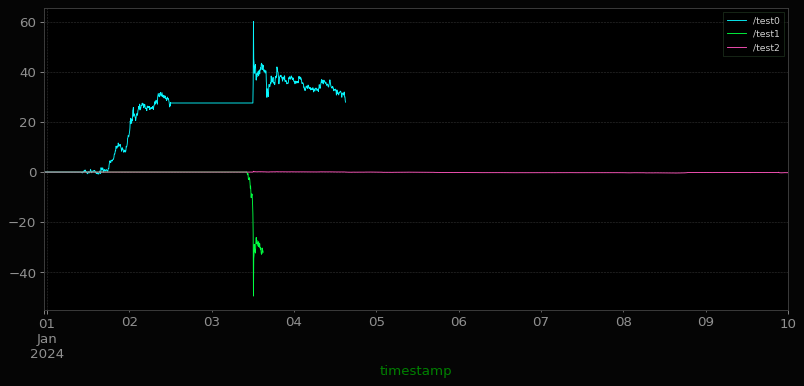

In [5]:
tearsheet(rep)

In [6]:
sigs = pd.DataFrame.from_dict({'BTCUSDT': {
    '2024-01-01 01:00': +0.1, 
    '2024-01-01 02:00': 0,
}})
sigs.index = pd.to_datetime(sigs.index)
QubxLogConfig.set_log_level("ERROR")

rep = simulate(
    {
        'test1': [TestStrategy(timeframe='15Min', fast_period=6, slow_period=50)],
        'test2': [TestStrategy(timeframe='15Min', fast_period=12, slow_period=24)],
        'test3': sigs,
    }, 
    r, 10000, ["BINANCE.UM:BTCUSDT"], 
    dict(type="ohlc", timeframe="5Min", nback=10),
    "5Min -1Sec",
    "vip0_usdt", 
    "2024-01-01", "2024-03-30", 
)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/102572 [00:00<?, ?it/s]

  0%|          | 0/102572 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

,Gain,Cagr,Sharpe,Qr,Max dd pct,Mdd usd,Sortino,Calmar,Tail ratio,Stability,Var,Avg return,Fees,Execs
/test1,-18.546843,-0.007418,-0.224979,0.000186,1.716011,172.087766,-0.409901,-0.500561,1.132268,0.005385,26.722381,-0.001910,155.730823,296.0
/test2,-59.710912,-0.023736,-0.781765,-0.143939,1.810529,181.749178,-1.380373,-1.447601,1.179788,0.170373,26.462098,-0.006458,168.231332,320.0
/test3,12.314823,0.251831,13.509256,0.332821,0.114826,11.510000,inf,NaN,19.000000,1.000000,3.970629,0.061574,2.125178,2.0


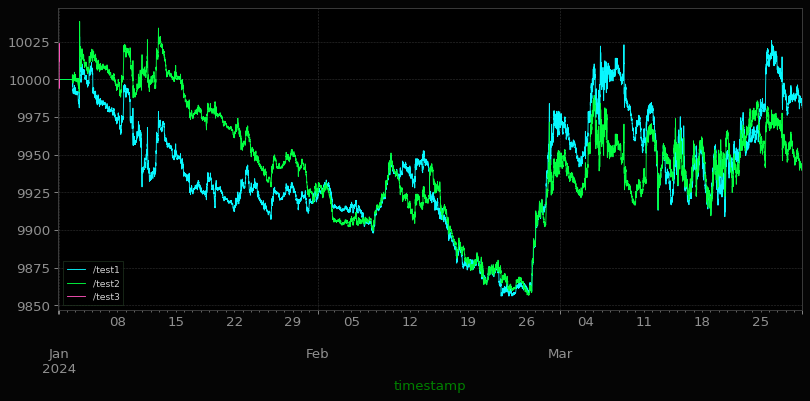

In [7]:
tearsheet(rep, False)

In [8]:
sigs = pd.DataFrame.from_dict({'BTCUSDT': {
    '2024-01-01 01:00': +0.1, 
    '2024-01-01 02:00': 0,
    '2024-01-01 03:00': -0.1,
    '2024-01-01 10:00': 0
}})
sigs.index = pd.to_datetime(sigs.index)
QubxLogConfig.set_log_level("ERROR")

rep = simulate( { 'test3': sigs }, 
    r, 10000, ["BINANCE.UM:BTCUSDT"], 
    dict(type="ohlc", timeframe="5Min", nback=10), "5Min -1Sec", "vip0_usdt", 
    "2024-01-01", "2024-01-02", 
)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/524 [00:00<?, ?it/s]

In [21]:
tearsheet(rep, False)

# Validation

In [17]:
import qubx.pandaz.ta as pta

In [57]:
r = MultiQdbConnector('xlydian-data')
ohlc = r.read('BINANCE.UM:BTCUSDT', '2024-01-01', '2024-01-02', AsOhlcvSeries('5Min'))

2024-07-25 10:33:17.962 [ 🐞 ] Connected to QuestDB at xlydian-data:8812
2024-07-25 10:33:17.962 [ 🐞 ] Closing connection
2024-07-25 10:33:17.962 [ 🐞 ] Closing connection
2024-07-25 10:33:17.962 [ 🐞 ] Closing connection
2024-07-25 10:33:17.962 [ 🐞 ] Closing connection


In [58]:
fast = sma(ohlc.close, 5)
slow = sma(ohlc.close, 15)
sigs = (((fast > slow) + (fast.shift(1) < slow.shift(1))) == 2) - (((fast < slow) + (fast.shift(1) > slow.shift(1))) == 2)
sigs = sigs.pd()
sigs = sigs[sigs != 0]
s1 = shift_series(sigs, '4Min59Sec').rename('BTCUSDT') / 100

In [59]:
ohlc_pd = r.read('BINANCE.UM:BTCUSDT', '2024-01-01', '2024-01-02', AsPandasFrame())
ohlc_pd = ohlc_resample(ohlc_pd, '5Min')
fast_pd = pta.sma(ohlc_pd.close, 5)
slow_pd = pta.sma(ohlc_pd.close, 15)

sigs = ((((fast_pd > slow_pd) & (fast_pd.shift(1) < slow_pd.shift(1)))) + 0) - ((((fast_pd < slow_pd) & (fast_pd.shift(1) > slow_pd.shift(1)))) + 0)
sigs = sigs[sigs != 0]
s2 = shift_series(sigs, '4Min59Sec').rename('BTCUSDT') / 100

In [71]:
s1

2024-01-01 02:19:59   -0.01
2024-01-01 04:49:59    0.01
2024-01-01 05:34:59   -0.01
2024-01-01 06:24:59    0.01
2024-01-01 11:34:59   -0.01
2024-01-01 12:19:59    0.01
2024-01-01 13:09:59   -0.01
2024-01-01 13:24:59    0.01
2024-01-01 14:09:59   -0.01
2024-01-01 15:24:59    0.01
2024-01-01 16:39:59   -0.01
2024-01-01 17:24:59    0.01
2024-01-01 17:39:59   -0.01
2024-01-01 17:54:59    0.01
2024-01-01 21:34:59   -0.01
2024-01-01 23:09:59    0.01
Name: BTCUSDT, dtype: float64

In [67]:
scols(s1, s2)

,BTCUSDT,BTCUSDT
2024-01-01 02:19:59,-0.01,-0.01
2024-01-01 04:49:59,0.01,0.01
2024-01-01 05:34:59,-0.01,-0.01
2024-01-01 06:24:59,0.01,0.01
2024-01-01 11:34:59,-0.01,-0.01
2024-01-01 12:19:59,0.01,0.01
2024-01-01 13:09:59,-0.01,-0.01
2024-01-01 13:24:59,0.01,0.01
2024-01-01 14:09:59,-0.01,-0.01
2024-01-01 15:24:59,0.01,0.01


In [69]:
rep1 = simulate(
    {
        # - generated signals as series
        "As Strategy": TestStrategy(timeframe="5Min", fast_period=5, slow_period=15),
        "Signals 1": s1,
        "Signals 2": s2,
    },

    r, 10000, ["BINANCE.UM:BTCUSDT"], 
    dict(type="ohlc", timeframe="5Min", nback=0),
    "5Min -1Sec",
    "vip0_usdt", 
    "2024-01-01", "2024-01-02", 
)

2024-07-25 10:35:13.120 [ ℹ️ ] TestStrategy new parameters:
	set timeframe <- 5Min
	set fast_period <- 5
	set slow_period <- 15


  0%|          | 0/3 [00:00<?, ?it/s]

2024-07-25 10:35:13.121 [ 🐞 ] 2024-01-01 00:00:00 Initiating simulated trading for binance.um for 10000 x 1.0 in USDT...
2024-07-25 10:35:13.121 [ ℹ️ ] SimulatedData.binance.um initialized
2024-07-25 10:35:13.121 [ 🐞 ] Triggering strategy on every 5Min bar after 4Min59S
2024-07-25 10:35:13.121 [ ℹ️ ] (StrategyContext) Subscribing to ohlc updates using {'timeframe': '5Min', 'nback': 0} for 
	['BTCUSDT'] 
2024-07-25 10:35:13.121 [ ℹ️ ]  -> Strategy started | 2024-01-01T00:00:00.000000000


  0%|          | 0/1156 [00:00<?, ?it/s]

2024-07-25 10:35:13.211 [ 🐞 ] [2024-01-01T00:00:00.001000000]: Invoking TestStrategy on_fit('2024-01-01 00:00:00', 'None')
2024-07-25 10:35:13.211 [ ℹ️ ]  -> Fit is called | fit_time: 2024-01-01 00:00:00 / prev: None
2024-07-25 10:35:13.316 [ ℹ️ ] BTCUSDT[1H] | 25 records
  2024-01-01T00:00:00.000000000 {o:42314.000000 | h:42335.800000 | l:42289.600000 | c:42331.900000 | v:289.641000}
  2023-12-31T23:00:00.000000000 {o:42294.800000 | h:42380.100000 | l:42083.100000 | c:42314.000000 | v:11676.465000}
  2023-12-31T22:00:00.000000000 {o:42559.000000 | h:42629.500000 | l:42111.900000 | c:42294.800000 | v:11952.346000}
   .......... 
  2023-12-31T02:00:00.000000000 {o:42212.000000 | h:42278.300000 | l:42001.000000 | c:42119.600000 | v:8615.563000}
  2023-12-31T01:00:00.000000000 {o:42395.100000 | h:42472.400000 | l:42187.900000 | c:42212.000000 | v:5407.971000}
  2023-12-31T00:00:00.000000000 {o:42202.700000 | h:42478.900000 | l:42177.600000 | c:42395.100000 | v:6632.428000}

2024-07-25 10:

  0%|          | 0/1112 [00:00<?, ?it/s]

2024-07-25 10:35:13.488 [ 🐞 ] [2024-01-01T00:00:00.001000000]: Invoking _GeneratedSignalsStrategy on_fit('2024-01-01 00:00:00', 'None')
2024-07-25 10:35:13.489 [ 🐞 ] [2024-01-01T00:00:00.001000000]: _GeneratedSignalsStrategy is fitted
2024-07-25 10:35:13.496 [ ℹ️ ] (StrategyContext) sending market sell for 0.01 of BTCUSDT ...
2024-07-25 10:35:13.497 [ 🐞 ] [OMS] BTCUSDT - SIM-ORDER-BTCUSDT-100001 MARKET SELL 0.01 executed at 42575.85
2024-07-25 10:35:13.497 [ ℹ️ ]   ::  traded -0.01 for BTCUSDT @ 42575.85 -> 0.00
2024-07-25 10:35:13.498 [ ℹ️ ] Order SIM-ORDER-BTCUSDT-100001 MARKET SELL 0.01 of BTCUSDT -> CLOSED
2024-07-25 10:35:13.498 [ 🐞 ] [SIM-ORDER-BTCUSDT-100001 / _GeneratedSignalsStrategy_BTCUSDT_17040672001] : MARKET SELL 0.01 of BTCUSDT  -> [CLOSED]
2024-07-25 10:35:13.499 [ 🐞 ] Executed -0.01 @ 42575.85 of BTCUSDT for order SIM-ORDER-BTCUSDT-100001
2024-07-25 10:35:13.504 [ ℹ️ ] (StrategyContext) sending market buy for 0.02 of BTCUSDT ...
2024-07-25 10:35:13.504 [ 🐞 ] [OMS] BTCU

  0%|          | 0/1112 [00:00<?, ?it/s]

2024-07-25 10:35:13.662 [ 🐞 ] [2024-01-01T00:00:00.001000000]: Invoking _GeneratedSignalsStrategy on_fit('2024-01-01 00:00:00', 'None')
2024-07-25 10:35:13.662 [ 🐞 ] [2024-01-01T00:00:00.001000000]: _GeneratedSignalsStrategy is fitted
2024-07-25 10:35:13.667 [ ℹ️ ] (StrategyContext) sending market sell for 0.01 of BTCUSDT ...
2024-07-25 10:35:13.667 [ 🐞 ] [OMS] BTCUSDT - SIM-ORDER-BTCUSDT-100001 MARKET SELL 0.01 executed at 42575.85
2024-07-25 10:35:13.668 [ ℹ️ ]   ::  traded -0.01 for BTCUSDT @ 42575.85 -> 0.00
2024-07-25 10:35:13.668 [ ℹ️ ] Order SIM-ORDER-BTCUSDT-100001 MARKET SELL 0.01 of BTCUSDT -> CLOSED
2024-07-25 10:35:13.668 [ 🐞 ] [SIM-ORDER-BTCUSDT-100001 / _GeneratedSignalsStrategy_BTCUSDT_17040672001] : MARKET SELL 0.01 of BTCUSDT  -> [CLOSED]
2024-07-25 10:35:13.669 [ 🐞 ] Executed -0.01 @ 42575.85 of BTCUSDT for order SIM-ORDER-BTCUSDT-100001
2024-07-25 10:35:13.675 [ ℹ️ ] (StrategyContext) sending market buy for 0.02 of BTCUSDT ...
2024-07-25 10:35:13.662 [ 🐞 ] [2024-01-0

c:\Users\dmitr\devs\Qubx\.venv\Lib\site-packages\scipy\stats\_distn_infrastructure.py:2246: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
c:\Users\dmitr\devs\Qubx\.venv\Lib\site-packages\scipy\stats\_distn_infrastructure.py:2247: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc
c:\Users\dmitr\devs\Qubx\.venv\Lib\site-packages\scipy\stats\_distn_infrastructure.py:2246: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
c:\Users\dmitr\devs\Qubx\.venv\Lib\site-packages\scipy\stats\_distn_infrastructure.py:2247: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


,Gain,Cagr,Sharpe,Qr,Max dd pct,Mdd usd,Sortino,Calmar,Tail ratio,Stability,Var,Avg return,Fees,Execs
/As Strategy,9.083837,0.180225,14.859306,0.320736,0.07263,7.266157,0.0,0.0,10.002917,1.0,2.250021,0.045417,6.632663,16.0
/Signals 1,4.101470,0.161454,0.000000,0.205300,0.07263,7.266157,0.0,0.0,1.000000,0.0,0.000000,0.041015,6.195530,16.0
/Signals 2,4.101470,0.161454,0.000000,0.205300,0.07263,7.266157,0.0,0.0,1.000000,0.0,0.000000,0.041015,6.195530,16.0


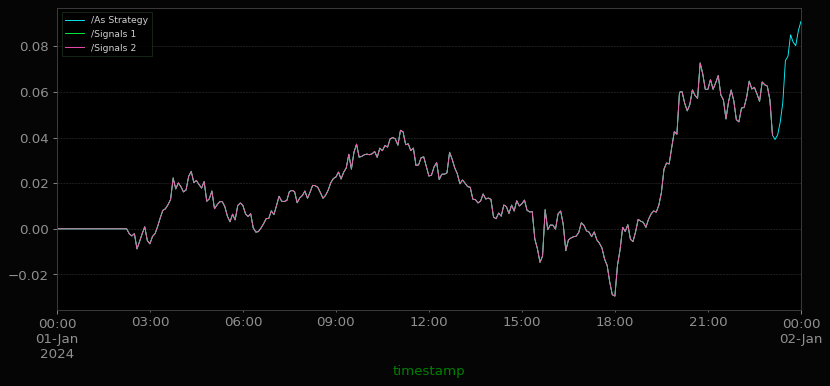

In [70]:
tearsheet(rep1)

In [72]:
all(rep1[0].executions_log[['filled_qty', 'price', 'side']] == rep1[1].executions_log[['filled_qty', 'price', 'side']])

True

In [75]:
tearsheet(rep1[0], False)

# Parameters variation example

In [46]:
from qubx.backtester import simulate, variate
from qubx.core.metrics import tearsheet, portfolio_metrics

In [92]:
sims = variate(
        TestStrategy, timeframe='5Min', 
        fast_period=range(5, 25, 5), 
        slow_period=range(25, 100, 25),
        conditions=lambda fast_period, slow_period: fast_period < slow_period
)
sims

{'TS_(fp=5,sp=25)': <__main__.TestStrategy at 0x16abedf8c50>,
 'TS_(fp=5,sp=50)': <__main__.TestStrategy at 0x16abedfb190>,
 'TS_(fp=5,sp=75)': <__main__.TestStrategy at 0x16abedfb290>,
 'TS_(fp=10,sp=25)': <__main__.TestStrategy at 0x16abedfa310>,
 'TS_(fp=10,sp=50)': <__main__.TestStrategy at 0x16abedfa390>,
 'TS_(fp=10,sp=75)': <__main__.TestStrategy at 0x16abedfa790>,
 'TS_(fp=15,sp=25)': <__main__.TestStrategy at 0x16abee18cd0>,
 'TS_(fp=15,sp=50)': <__main__.TestStrategy at 0x16abee1bb90>,
 'TS_(fp=15,sp=75)': <__main__.TestStrategy at 0x16abee1be50>,
 'TS_(fp=20,sp=25)': <__main__.TestStrategy at 0x16abee1af90>,
 'TS_(fp=20,sp=50)': <__main__.TestStrategy at 0x16abee1b490>,
 'TS_(fp=20,sp=75)': <__main__.TestStrategy at 0x16abee1bf90>}

In [90]:
QubxLogConfig.set_log_level("WARNING")

rep2 = simulate(
    sims,
    r, 10000, ["BINANCE.UM:BTCUSDT"], 
    dict(type="ohlc", timeframe="5Min", nback=0),
    "5Min -1Sec",
    "vip0_usdt", 
    "2024-01-01", "2024-01-05", 
)

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/4612 [00:00<?, ?it/s]

  0%|          | 0/4612 [00:00<?, ?it/s]

  0%|          | 0/4612 [00:00<?, ?it/s]

  0%|          | 0/4612 [00:00<?, ?it/s]

  0%|          | 0/4612 [00:00<?, ?it/s]

  0%|          | 0/4612 [00:00<?, ?it/s]

  0%|          | 0/4612 [00:00<?, ?it/s]

  0%|          | 0/4612 [00:00<?, ?it/s]

  0%|          | 0/4612 [00:00<?, ?it/s]

  0%|          | 0/4612 [00:00<?, ?it/s]

  0%|          | 0/4612 [00:00<?, ?it/s]

  0%|          | 0/4612 [00:00<?, ?it/s]

,Gain,Cagr,Sharpe,Qr,Max dd pct,Mdd usd,Sortino,Calmar,Tail ratio,Stability,Var,Avg return,Fees,Execs
"/TS_(fp=5,sp=25)",-20.643830,-0.140028,-5.787193,-0.096723,0.600755,60.302701,-7.680846,-50.565233,0.273898,0.742442,24.157876,-0.041248,30.084830,69.0
"/TS_(fp=5,sp=50)",-10.806998,-0.075899,-5.269831,-0.151505,0.443559,44.497650,-7.651961,-40.827460,0.572468,0.853461,13.679865,-0.021599,18.327498,42.0
"/TS_(fp=5,sp=75)",4.551038,0.033773,1.755941,-0.008475,0.529792,53.225246,3.104883,22.314590,0.856987,0.335066,13.716351,0.009140,12.059462,28.0
"/TS_(fp=10,sp=25)",3.892576,0.028818,1.470777,0.026368,0.338203,33.930341,3.732191,32.872362,1.702255,0.122490,14.171903,0.007825,22.984424,53.0
"/TS_(fp=10,sp=50)",-0.688277,-0.005012,-0.476472,-0.007956,0.368830,37.006686,-0.863034,-6.168133,0.901142,0.534465,8.186381,-0.001365,14.806777,34.0
"/TS_(fp=10,sp=75)",0.059183,0.000432,0.029897,-0.036476,0.576867,57.958717,0.053334,0.278509,0.891287,0.651228,15.063365,0.000160,9.847817,24.0
"/TS_(fp=15,sp=25)",-5.794787,-0.041431,-2.608358,-0.068168,0.404406,40.560078,-5.062643,-43.105468,1.130419,0.008398,13.617091,-0.011564,24.762787,57.0
"/TS_(fp=15,sp=50)",1.006098,0.007371,0.688831,-0.127299,0.422747,42.410346,1.209173,7.829541,0.794934,0.358523,8.059308,0.002025,12.132402,28.0
"/TS_(fp=15,sp=75)",0.007829,0.000057,0.010044,-0.021913,0.535712,53.806222,0.021075,0.041974,1.171369,0.838946,12.628597,0.000045,8.996171,21.0
"/TS_(fp=20,sp=25)",-32.013412,-0.208696,-16.726063,-1.648356,0.604685,60.639138,-16.093101,-75.305161,0.036655,0.885561,17.178323,-0.064088,28.443412,65.0


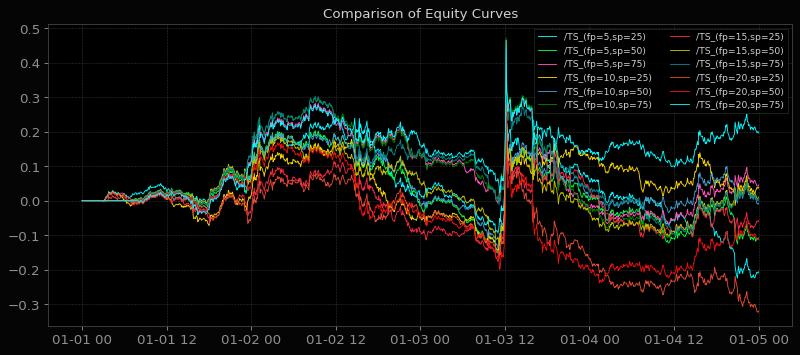

In [86]:
tearsheet(rep2)

# Signals viewer

In [125]:
from qubx.core.metrics import chart_signals

In [102]:
ohlc_pd = r.read('BINANCE.UM:BTCUSDT', '2024-01-01', '2024-02-02', AsPandasFrame())
ohlc_pd = ohlc_resample(ohlc_pd, '5Min')

In [132]:
chart_signals(rep2[-1], "BTCUSDT", ohlc_pd, overlay=[
    pta.sma(ohlc_pd.close, 20),
    pta.sma(ohlc_pd.close, 75),
    ])

(None, None)